In [6]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib.gridspec as gridspec
import random
from astroML.correlation import two_point
from scipy import spatial
from tqdm import *

cdm = h5py.File('Data/COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5', 'r')
wdm = h5py.File('Data/COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5', 'r')

print(cdm,wdm)

<HDF5 file "COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)> <HDF5 file "COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)>


# Access the masses and positions of CDM and WDM halos

In [8]:
# Access mass/position for wdm/cdm
print(list(cdm.keys()),list(wdm.keys()))

cdm_mass = cdm['SubhaloMass'][:]
cdm_position = cdm['SubhaloPos'][:]

wdm_mass = wdm['SubhaloMass'][:]
wdm_position = wdm['SubhaloPos'][:]

cdm_mass, cdm_position, wdm_mass, wdm_position

['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos'] ['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos']


(array([1.87617493e+14, 1.84468594e+14, 6.89978024e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[10.93832207, 81.23078918, 54.77935028],
        [17.94562721, 79.86347961, 53.3843956 ],
        [15.62266159, 78.18474579, 52.83857346],
        ...,
        [ 1.47748184,  3.54455233, 99.53264618],
        [99.32190704,  2.56014371,  2.57368279],
        [99.0621109 ,  4.18381071,  2.89533401]]),
 array([1.89941540e+14, 1.86912732e+14, 6.83256610e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[1.80150642e+01, 7.98655701e+01, 5.34328232e+01],
        [1.09048624e+01, 8.12610779e+01, 5.48179703e+01],
        [1.56323385e+01, 7.81665344e+01, 5.28157997e+01],
        ...,
        [6.02296066e+00, 5.05078554e+00, 9.79758301e+01],
        [5.75055540e-01, 3.26677370e+00, 3.52767438e-01],
        [2.07897183e-03, 3.23730040e+00, 9.97708917e-01]]))

# Filter out central halos smaller than the resolution limit

In [17]:
m_res = 8.8*10**6*50
m_res

440000000.0

In [22]:
# find the indices of all the central halos
cdm_central_ind = np.where((cdm['IsCentral'][:] == 1)&(cdm_mass>m_res))[0]

print(cdm_central_ind)
print(len(cdm_mass[cdm_central_ind]))
print(cdm['IsCentral'][:][cdm_central_ind])

wdm_central_ind = np.where((wdm['IsCentral'][:] == 1)&(wdm_mass>m_res))[0]

[      0   20093   40287 ... 2633808 2633809 2633811]
1686837
[1 1 1 ... 1 1 1]


# Create trees of the wdm and cdm positions

In [23]:
cdm_position_central = cdm_position[cdm_central_ind]
wdm_position_central = wdm_position[wdm_central_ind]

cdm_tree = spatial.cKDTree(cdm_position)
wdm_tree = spatial.cKDTree(wdm_position)

# Find the mass of a 5 Mpc sphere around each central halo
### CDM Halos 

In [24]:
# create an empty array for the mass of the spheres
cdm_5Mpc_sphere_mass = []

#iterate through each central halo
for i in trange(len(cdm_central_ind)):
    #find the indices for all halos in a 5 Mpc radius around each central halo
    cdm_ind = cdm_tree.query_ball_point(cdm_position_central[i], 5)
    #sum the mass of these halos
    cdm_5Mpc_sphere_mass.append(np.sum(cdm_mass[cdm_ind]))

100%|██████████| 1686837/1686837 [37:03<00:00, 758.53it/s] 


In [26]:
cdm_5Mpc_sphere_mass=np.array(cdm_5Mpc_sphere_mass)
np.savetxt("cdm_5Mpc_sphere_mass_v2.txt", cdm_5Mpc_sphere_mass, fmt = "%f")
len(cdm_5Mpc_sphere_mass), len(cdm_central_ind)

(1686837, 1686837)

### WDM Halos

In [28]:
# create an empty array for the mass of the spheres
wdm_5Mpc_sphere_mass = []

#iterate through each central halo
for i in trange(len(wdm_central_ind)):
    #find the indices for all halos in a 5 Mpc radius around each central halo
    wdm_ind = wdm_tree.query_ball_point(wdm_position_central[i], 5)
    #sum the mass of these halos
    wdm_5Mpc_sphere_mass.append(np.sum(wdm_mass[wdm_ind]))

100%|██████████| 1123039/1123039 [15:46<00:00, 1186.15it/s]


In [10]:
wdm_5Mpc_sphere_mass=np.array(wdm_5Mpc_sphere_mass)
np.savetxt("wdm_5Mpc_sphere_mass_v2.txt", wdm_5Mpc_sphere_mass, fmt = "%f")
print(len(wdm_5Mpc_sphere_mass), len(wdm_central_ind))
cdm_5Mpc_sphere_mass,wdm_5Mpc_sphere_mass

2609122 2609122


(array([2.93983253e+14, 5.90015914e+14, 3.62308758e+14, ...,
        8.93088892e+12, 1.29342030e+13, 1.31540498e+13]),
 array([3.67286503e+14, 5.83136276e+14, 3.61040039e+14, ...,
        2.98641776e+12, 2.02820383e+12, 2.04709863e+12]))

# Subtract the mass of each central halo from each summed mass

In [11]:
cdm_sphere_mass=cdm_5Mpc_sphere_mass-cdm_mass[cdm_central_ind]
wdm_sphere_mass=wdm_5Mpc_sphere_mass-wdm_mass[wdm_central_ind]

In [12]:
cdm_sphere_mass,wdm_sphere_mass

(array([1.06365761e+14, 2.16812515e+14, 1.24312859e+14, ...,
        8.93071291e+12, 1.29340270e+13, 1.31538738e+13]),
 array([1.77344964e+14, 1.99599119e+14, 1.18699043e+14, ...,
        2.98624175e+12, 2.02802781e+12, 2.04692262e+12]))

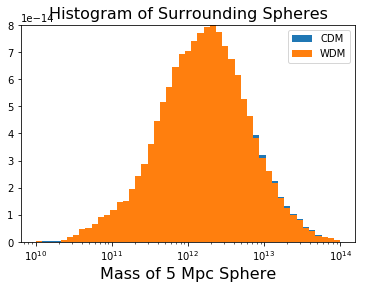

In [31]:
bins=np.logspace(np.log10(1e10),np.log10(1e14), 50)
plt.hist(cdm_sphere_mass, bins=bins,label='CDM',density=True)
plt.hist(wdm_sphere_mass,bins=bins,label='WDM',density=True)
plt.xscale("Log")
plt.xlabel("Mass of 5 Mpc Sphere", fontsize=16)
plt.title("Histogram of Surrounding Spheres", fontsize=16)
plt.legend()
plt.savefig('Mass_Histogram.pdf')
plt.show()

In [32]:
cdm_mass_central=cdm_mass[cdm_central_ind]
wdm_mass_central=wdm_mass[wdm_central_ind]

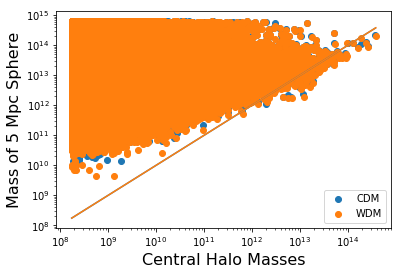

In [33]:
plt.scatter(cdm_mass_central,cdm_sphere_mass,label='CDM')
plt.scatter(wdm_mass_central,wdm_sphere_mass,label='WDM')
plt.plot([np.min(cdm_mass_central),np.max(cdm_mass_central)],[np.min(cdm_mass_central),np.max(cdm_mass_central)])
plt.plot([np.min(wdm_mass_central),np.max(wdm_mass_central)],[np.min(wdm_mass_central),np.max(wdm_mass_central)])
plt.xscale("Log")
plt.yscale("Log")
plt.xlabel('Central Halo Masses', fontsize=16)
plt.ylabel('Mass of 5 Mpc Sphere', fontsize=16)
plt.legend()
plt.savefig('Mass_Scatter.pdf')
plt.show()

In [34]:
print(cdm_mass_central[0],cdm_mass_central[-1])
print(np.min(cdm_mass_central),np.max(cdm_mass_central))
cdm_mass_central

187617492598784.0 176011232.0
176011232.0 373203398557696.0


array([1.87617493e+14, 3.73203399e+14, 2.37995899e+14, ...,
       1.76011232e+08, 1.76011232e+08, 1.76011232e+08])

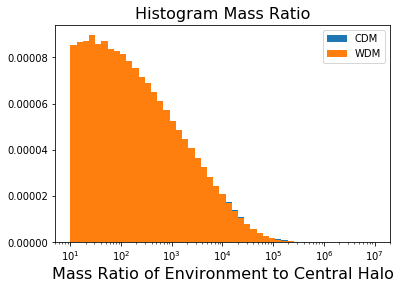

In [35]:
bins=np.logspace(np.log10(1e1),np.log10(1e7), 50)
plt.hist(cdm_sphere_mass/cdm_mass_central,bins=bins,label='CDM', normed=True)
plt.hist(wdm_sphere_mass/wdm_mass_central,bins=bins,label='WDM',normed=True)
plt.xscale("Log")
plt.xlabel("Mass Ratio of Environment to Central Halo", fontsize=16)
plt.title("Histogram Mass Ratio", fontsize=16)
plt.legend()
plt.savefig('Mass_Ratio_Histogram.pdf')
plt.show()

# Calculate the mass of a 10 Mpc sphere
### Calculate CDM first

In [39]:
# create an empty array for the mass of the spheres
cdm_10Mpc_sphere_mass = []

#iterate through each central halo
for i in range(len(cdm_central_ind)):
    #find the indices for all halos in a 10 Mpc radius around each central halo
    cdm_ind = cdm_tree.query_ball_point(cdm_position_central[i], 10)
    #sum the mass of these halos
    cdm_10Mpc_sphere_mass.append(np.sum(cdm_mass[cdm_ind]))

In [40]:
cdm_10Mpc_sphere_mass=np.array(cdm_10Mpc_sphere_mass)
np.savetxt("cdm_10Mpc_sphere_mass_v2.txt", cdm_10Mpc_sphere_mass, fmt = "%f")
len(cdm_10Mpc_sphere_mass), len(cdm_central_ind)

(3961192, 3961192)

### Calculate WDM next

In [41]:
# create an empty array for the mass of the spheres
wdm_10Mpc_sphere_mass = []

#iterate through each central halo
for i in range(len(wdm_central_ind)):
    #find the indices for all halos in a 10 Mpc radius around each central halo
    wdm_ind = wdm_tree.query_ball_point(wdm_position_central[i], 10)
    #sum the mass of these halos
    wdm_10Mpc_sphere_mass.append(np.sum(wdm_mass[wdm_ind]))

In [42]:
wdm_10Mpc_sphere_mass=np.array(wdm_10Mpc_sphere_mass)
np.savetxt("wdm_10Mpc_sphere_mass_v2.txt", wdm_10Mpc_sphere_mass, fmt = "%f")
print(len(wdm_10Mpc_sphere_mass), len(wdm_central_ind))
cdm_10Mpc_sphere_mass,wdm_10Mpc_sphere_mass

2609122 2609122


(array([8.96204124e+14, 8.72560969e+14, 4.63726649e+14, ...,
        1.50589487e+13, 1.78903889e+13, 2.07299164e+13]),
 array([9.00138930e+14, 8.61649026e+14, 4.55662479e+14, ...,
        3.40352388e+13, 6.10856660e+12, 6.11876645e+12]))

# Now subtract the mass of a 5 Mpc sphere!

In [43]:
cdm_envelope_mass=cdm_10Mpc_sphere_mass-cdm_5Mpc_sphere_mass
wdm_envelope_mass=wdm_10Mpc_sphere_mass-wdm_5Mpc_sphere_mass

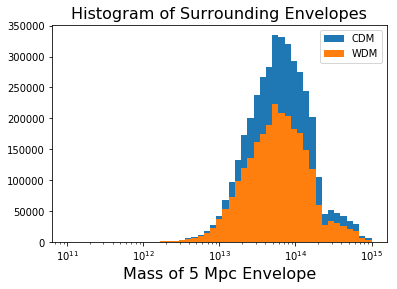

In [44]:
bins=np.logspace(np.log10(1e11),np.log10(1e15), 50)
plt.hist(cdm_envelope_mass, bins=bins,label='CDM')
plt.hist(wdm_envelope_mass,bins=bins,label='WDM')
plt.xscale("Log")
plt.xlabel("Mass of 5 Mpc Envelope", fontsize=16)
plt.title("Histogram of Surrounding Envelopes", fontsize=16)
plt.legend()
plt.savefig('Envelope_Mass_Histogram.pdf')
plt.show()